In [4]:
from google.colab import files
files.upload()

Saving jiwon-results-json-200-answer.json to jiwon-results-json-200-answer.json


{'jiwon-results-json-200-answer.json': b'{\n    "diary_1": {\n        "diary_entry": "As soon as I heard that Jimmy O. Yang was doing a nationwide tour in March, I booked my ticket right away. There are still a few months left, but I\xe2\x80\x99m so excited that I watch his shorts every day\xe2\x80\x94it already seems like it\xe2\x80\x99s going to be fun. But I\xe2\x80\x99m worried there might not be any parking spots nearby. Not having a place to park would be such a hassle. Oh well, let\xe2\x80\x99s just think positive!",\n        "extracted_keywords": {\n            "event": [\n                "Jimmy O. Yang nationwide tour"\n            ],\n            "action": [\n                "booked my ticket",\n                "watch his shorts"\n            ],\n            "time": [\n                "March",\n                "every day"\n            ],\n            "thoughts": [\n                "so excited",\n                "worried",\n                "would be such a hassle",\n          

# T5-Large Model Fine-tuning

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import json

# json file load
date="1120"
myfile = "jiwon-results-json-200-answer.json"
with open(myfile, 'r') as f:
    data = json.load(f)

# load T5 model and tokinizer
model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# creating input and output text
def prepare_data(data):
    input_texts = []
    target_texts = []

    for diary_id, diary_content in data.items():
        diary_entry = diary_content["diary_entry"]
        keywords = diary_content["extracted_keywords"]

        # input text
        input_text = f"Extract Event, Action, Time, and Thoughts from: '{diary_entry}'"

        # output text(json format)
        target_text = json.dumps(keywords)

        input_texts.append(input_text)
        target_texts.append(target_text)

    return input_texts, target_texts

# input, target text created from json file data
input_texts, target_texts = prepare_data(data)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()

# test with sample data
def test_model(epoch, input_text):
    model.eval()
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    with torch.no_grad():
        generated_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
        output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"\nEpoch {epoch + 1} Test Output:", output_text)

# sample data creation
def sample_data(diary_entry):
    sample = f"Extract Event, Action, Time, and Thoughts from: '{diary_entry}'"
    return sample

train_sample = """
I wasn’t able to attend the meeting with Dan. My car broke down in the middle of nowhere, so I had to pull over and wait for help. It was a total disaster. I had to rearrange my schedule as soon as I got back.
"""
test_sample_1 = """
I went to a Green Day concert, but it rained. They were the first band I liked when I was young, so I felt a bit disappointed. The concert atmosphere wasn’t as great as I expected. On the way back, I had my favorite ice cream, but it didn’t make me very happy. Maybe I just wasn’t in a good mood today. I hope they go on a national tour again next year.
"""
test_sample_2 = """
Arcane Season 2 was released yesterday. There is only three episodes for now and I have to wait until November 23rd to watch all the episodes. The first three episodes were awesome. I've never seen something that good. I need to tell all my friends to start watching!
"""

train_data_sample = sample_data(train_sample)
test_data_sample_1 = sample_data(test_sample_1)
test_data_sample_2 = sample_data(test_sample_2)

# fine-tuning
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    num_samples = len(input_texts)

    for input_text, target_text in zip(input_texts, target_texts):
        # input,output tokenize
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        labels = tokenizer(target_text, return_tensors="pt").input_ids

        # loss calculation
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # average loss for each epoch 
    avg_loss = total_loss / num_samples
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss}")

    # sample data testing each epoch
    print(f"\nAfter Epoch {epoch + 1} Test Outputs:")
    print("Train Sample Test Output:")
    test_model(epoch, train_data_sample)
    print("\nTest Sample 1 Test Output:")
    test_model(epoch, test_data_sample_1)
    print("\nTest Sample 2 Test Output:")
    test_model(epoch, test_data_sample_2)

    # save model
    model_save_path = f"{date}_t5_large_finetuned_epoch_{epoch + 1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved after epoch {epoch + 1} to {model_save_path}")

Epoch 1 Average Loss: 0.8273157893121242

After Epoch 1 Test Outputs:
Train Sample Test Output:

Epoch 1 Test Output: "event": ["meeting with Dan"], "action": ["car broke down", "pull over and wait for help"], "time": [], "thoughts": ["it was a total disaster", "had to rearrange my schedule"]

Test Sample 1 Test Output:

Epoch 1 Test Output: "event": ["Green Day concert"], "action": ["went to a Green Day concert", "had my favorite ice cream"], "time": [], "thoughts": ["felt a bit disappointed", "hope they go on a national tour again next year"]

Test Sample 2 Test Output:

Epoch 1 Test Output: "event": ["release of Arcane Season 2"], "action": ["wait until November 23rd to watch all the episodes"], "time": [], "thoughts": ["the first three episodes were awesome", "need to tell all my friends to start watching"]
Model saved after epoch 1 to 1120_t5_large_finetuned_epoch_1.pt
Epoch 2 Average Loss: 0.2869477351009846

After Epoch 2 Test Outputs:
Train Sample Test Output:

Epoch 2 Test Out

In [ ]:
# load model by epoch
epoch_to_load = 3  # epoch number
model_path = f"{date}_t5_large_finetuned_epoch_{epoch_to_load}.pt"
model.load_state_dict(torch.load(model_path))
model.eval() 

# test diary entry
test_sample = """
This morning was life-changing. I took a walk on the beach, with the waves crashing like a soundtrack.
Then, I stopped for a black americano, the most exciting drink on the menu, and stared out the window in awe of life’s mundanity.
The highlight of my day? The peacefulness. I’ll spend the rest of the day recovering from this thrilling routine.
Who knew mornings could be this uneventful yet somehow fulfilling?
"""

# generate output
def test_model(model, tokenizer, diary_entry):
    input_text = f"Extract Event, Action, Time, and Thoughts from: '{diary_entry}'"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    with torch.no_grad():
        generated_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
        output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return output_text

# test
output = test_model(model, tokenizer, test_sample)
print("Generated Output:", output)

NameError: name 'model' is not defined

In [3]:
model_file = f"{date}_t5_large_finetuned_epoch_3.pt"
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# T5-large loss graph

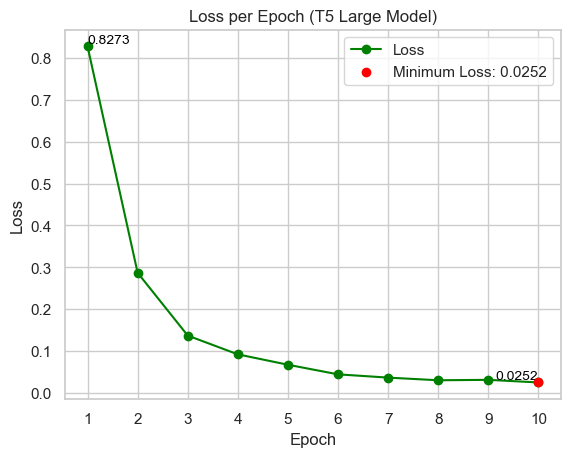

In [8]:
import matplotlib.pyplot as plt

# Loss values for each epoch
epoch_losses = [
    0.8273157893121242,
    0.2869477351009846,
    0.1371227809553966,
    0.09230907134711742,
    0.06752585482550785,
    0.04455707067507319,
    0.03678727552585769,
    0.030457746269821655,
    0.03146903755608946,
    0.02524146889380063
]

# Epochs
epochs = range(1, len(epoch_losses) + 1)

# Plotting
plt.plot(epochs, epoch_losses, marker='o', color='green', label='Loss')

# Highlighting minimum loss point
min_loss_epoch = epochs[epoch_losses.index(min(epoch_losses))]
min_loss_value = min(epoch_losses)
plt.scatter(min_loss_epoch, min_loss_value, color='red', label=f'Minimum Loss: {min_loss_value:.4f}', zorder=5)

# Showing the first and last loss values in black
first_loss_epoch = epochs[0]
first_loss_value = epoch_losses[0]
last_loss_epoch = epochs[-1]
last_loss_value = epoch_losses[-1]

plt.text(first_loss_epoch, first_loss_value, f'{first_loss_value:.4f}', color='black', fontsize=10, ha='left', va='bottom')
plt.text(last_loss_epoch, last_loss_value, f'{last_loss_value:.4f}', color='black', fontsize=10, ha='right', va='bottom')

plt.title("Loss per Epoch (T5 Large Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Save as image
plt.savefig("t5_large_loss_per_epoch.png", dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

# T5-base loss graph

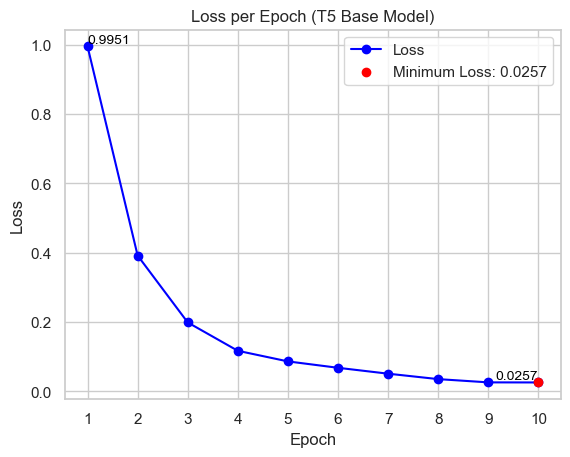

In [10]:
import matplotlib.pyplot as plt

# Loss values for each epoch for T5-base model
epoch_losses = [
    0.9951235933601856,
    0.3917671799659729,
    0.1988119487185031,
    0.11703530049882829,
    0.08644894685130566,
    0.06801330523565412,
    0.05101193245674949,
    0.03534096991061233,
    0.025967181373853235,
    0.025741571015387307
]


epochs = range(1, len(epoch_losses) + 1)
plt.plot(epochs, epoch_losses, marker='o', color='blue', label='Loss')
min_loss_epoch = epochs[epoch_losses.index(min(epoch_losses))]
min_loss_value = min(epoch_losses)
plt.scatter(min_loss_epoch, min_loss_value, color='red', label=f'Minimum Loss: {min_loss_value:.4f}', zorder=5)

first_loss_epoch = epochs[0]
first_loss_value = epoch_losses[0]
last_loss_epoch = epochs[-1]
last_loss_value = epoch_losses[-1]

plt.text(first_loss_epoch, first_loss_value, f'{first_loss_value:.4f}', color='black', fontsize=10, ha='left', va='bottom')
plt.text(last_loss_epoch, last_loss_value, f'{last_loss_value:.4f}', color='black', fontsize=10, ha='right', va='bottom')

plt.title("Loss per Epoch (T5 Base Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.savefig("t5_base_loss_per_epoch.png", dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()